### Detecting suicide ideation in online posts from Twitter using Machine Learning classifiers

In [1]:
!pip install  unidecode

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import warnings
warnings.filterwarnings('ignore')

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Visualisation libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning Libraries
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest,chi2,f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier,VotingClassifier
# AdaBoostClassifier,GradientBoostingClassifier,BaggingClassifier
from sklearn.metrics import classification_report , confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

import pickle
import string
import re
import unidecode

# Text Processing libraries
import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [3]:
df = pd.read_csv('Suicide_Ideation_Twitter.csv',encoding='utf-8',engine='python')

print(df.shape)

# df = df.sample(6000, random_state=47)
# df.drop('Unnamed: 0', axis=1,inplace=True)
df.head()

(1787, 2)


,Tweet,Suicide
0,making some lunch,Not Suicide post
1,@Alexia You want his money.,Not Suicide post
2,@dizzyhrvy that crap took me forever to put to...,Potential Suicide post
3,@jnaylor #kiwitweets Hey Jer! Since when did y...,Not Suicide post
4,Trying out &quot;Delicious Library 2&quot; wit...,Not Suicide post


In [4]:
df.rename(columns={'Tweet':'text','Suicide':'class'},inplace=True)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1787 entries, 0 to 1786
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    1785 non-null   object
 1   class   1787 non-null   object
dtypes: object(2)
memory usage: 28.1+ KB


In [6]:
df['text'] = df['text'].astype(str)
df['class'] = df['class'].astype(str)
df['text'] = df['text'].str.lower()
df['class'] = df['class'].str.lower()

In [7]:
df.reset_index(inplace=True,drop=True)

In [8]:
df[df['text'].isnull()].index

Int64Index([], dtype='int64')

In [9]:
from empath import Empath
lexicon = Empath()

In [10]:
# for i in range(len(df)) :
    
#     txt = df.loc[i,'text']
# #     d=lexicon.analyze(txt,categories=['negative_emotion','positive_emotion'],normalize=True)
#     d=lexicon.analyze(txt,categories=['celebration','cheerfulness','death','violence','negative_emotion','postive_emotion'],normalize=True)
#     df['celebration'] = d['celebration']
#     df['cheerfulness'] = d['cheerfulness']
#     df['death'] = d['death']
#     df['violence'] = d['violence']
#     df['negative_emotion'] = d['negative_emotion']
#     df['positive_emotion'] = d['positive_emotion']

In [11]:
df['class'] = np.where(df['class'].str.contains('not'),0,1)

In [12]:
df.to_csv('suicide_detection_twitter_modified.csv')

In [13]:
def rem_whitespace(text):
    text = text.strip()
    return " ".join(text.split())

def rem_url(text):
    return re.sub(r'http\S+', '', text)

def rem_email(text):
    return re.sub(r'\S+@\S+', '', text)

def rem_symbols_digits(text):
    return re.sub('[^a-zA-Z\s]', ' ', text)

def rem_emoji(text):
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def rem_special(text):
    return text.replace("\r", " ").replace("\n", " ").replace("    ", " ").replace('"', '')

def rem_accented_chars(text):
    text = unidecode.unidecode(text)
    return text

def fix_lengthening(text):
     return re.sub(r"(.)\1{2,}",r'\1',text)


In [14]:
from nltk import word_tokenize, sent_tokenize
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [15]:
# Looking at a sample tweet
df['text'][30]

"@domselinakyle that sounds so terrible that's how i was when my dad still lived w me but i hope it gets better forâ\x80¦ https://t.co/oah2tunbxt"

In [16]:
df['text']   = df['text'].apply(lambda t : rem_emoji(t))
df['text']   = df['text'].apply(lambda t : rem_symbols_digits(t))
df['text']   = df['text'].apply(lambda t : rem_url(t))
df['text']   = df['text'].apply(lambda t : rem_email(t))
df['text']   = df['text'].apply(lambda t : rem_special(t))
df['text']   = df['text'].apply(lambda t : rem_accented_chars(t))
df['text']   = df['text'].apply(lambda t : fix_lengthening(t))
df['text']   = df['text'].apply(lambda t : rem_whitespace(t))

In [17]:
df['text'][30]

'domselinakyle that sounds so terrible that s how i was when my dad still lived w me but i hope it gets better for t co oah tunbxt'

In [18]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [19]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
df['text'] = df['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

In [20]:
df['text'] = df['text'].apply(lambda x:nltk.word_tokenize(x))

In [21]:
df['text'][30]

['domselinakyle',
 'sounds',
 'terrible',
 'dad',
 'still',
 'lived',
 'w',
 'hope',
 'gets',
 'better',
 'co',
 'oah',
 'tunbxt']

In [22]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [23]:
wl = WordNetLemmatizer()

In [24]:
df['text'] = df['text'].apply(lambda x: [wl.lemmatize(i) for i in x])

In [25]:
df['text']=df['text'].apply(lambda x : ' '.join(x))

In [26]:
df.to_csv('suicide_clean.csv')

In [ ]:
df['text'] = np.where(df['text']=='',np.NaN,df['text'])

In [ ]:
df.dropna(subset=['text'],inplace=True)

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1787 entries, 0 to 1786
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    1787 non-null   object
 1   class   1787 non-null   int32 
dtypes: int32(1), object(1)
memory usage: 21.1+ KB


In [ ]:
df.reset_index(drop=True,inplace=True)

In [29]:
for i in range(len(df)) :
    
    txt = df.loc[i,'text']
    d=dict()
    d=lexicon.analyze(txt,normalize=True)
    for k in d.keys() :
        df.loc[i,k] = d[k]
   

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1787 entries, 0 to 1786
Columns: 196 entries, text to musical
dtypes: float64(194), int32(1), object(1)
memory usage: 2.7+ MB


In [31]:
df.head()

,text,class,help,office,dance,money,wedding,domestic_work,sleep,medical_emergency,...,weapon,children,monster,ocean,giving,contentment,writing,rural,positive_emotion,musical
0,making lunch,0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,alexia want money,0,0.0,0.0,0.0,0.333333,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,dizzyhrvy crap took forever put together going...,1,0.0,0.0,0.0,0.000000,0.0,0.0,0.1,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,jnaylor kiwitweets hey jer since start twittering,0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,trying quot delicious library quot mixed resul...,0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [32]:
df_corr = df.drop(columns=['text']).corr()

In [33]:
df_corr['class'].sort_values(ascending=False).head(11)[1:]

negative_emotion     0.416247
death                0.316546
hate                 0.265771
swearing_terms       0.262253
kill                 0.252722
medical_emergency    0.245316
envy                 0.217391
shame                0.199403
violence             0.193108
pain                 0.177900
Name: class, dtype: float64

In [34]:
top_pos_corr = df_corr['class'].sort_values(ascending=False).head(11)[1:].index.tolist()

top_pos_corr

['negative_emotion',
 'death',
 'hate',
 'swearing_terms',
 'kill',
 'medical_emergency',
 'envy',
 'shame',
 'violence',
 'pain']

In [35]:
top_neg_corr = df_corr['class'].sort_values(ascending=False).tail(10).index.tolist()

top_neg_corr

['wedding',
 'cheerfulness',
 'childish',
 'internet',
 'party',
 'friends',
 'social_media',
 'achievement',
 'celebration',
 'optimism']

In [36]:
df[top_pos_corr+top_neg_corr]

,negative_emotion,death,hate,swearing_terms,kill,medical_emergency,envy,shame,violence,pain,wedding,cheerfulness,childish,internet,party,friends,social_media,achievement,celebration,optimism
0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000
1,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000
2,0.000000,0.0,0.0,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000
3,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000
4,0.052632,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1782,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.200000,0.0,0.000000,0.0,0.200000
1783,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.285714,0.0,0.142857
1784,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.166667,0.0,0.000000,0.166667,0.0,0.000000,0.0,0.000000
1785,0.071429,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.071429,0.000000,0.0,0.000000,0.0,0.071429


In [37]:
df_2 = df[top_pos_corr+top_neg_corr]

df_2

,negative_emotion,death,hate,swearing_terms,kill,medical_emergency,envy,shame,violence,pain,wedding,cheerfulness,childish,internet,party,friends,social_media,achievement,celebration,optimism
0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000
1,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000
2,0.000000,0.0,0.0,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000
3,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000
4,0.052632,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1782,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.200000,0.0,0.000000,0.0,0.200000
1783,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.285714,0.0,0.142857
1784,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.166667,0.0,0.000000,0.166667,0.0,0.000000,0.0,0.000000
1785,0.071429,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.071429,0.000000,0.0,0.000000,0.0,0.071429


In [38]:
# from sklearn.preprocessing import LabelEncoder

# le=LabelEncoder()

# df['class']=le.fit_transform(df['class'])

In [39]:
# df['class'].value_counts()

In [40]:
X = df['text']
# y = df['class']

In [41]:
vectorizer = TfidfVectorizer(min_df=50,max_features=6000,ngram_range=(1,2))
x =  vectorizer.fit_transform(X).toarray()

In [42]:
vectorizer.vocabulary_

{'want': 38,
 'going': 13,
 'go': 12,
 'day': 5,
 'good': 14,
 'got': 15,
 'na': 27,
 'one': 29,
 'people': 30,
 'co': 3,
 'time': 35,
 'hate': 16,
 'life': 21,
 'die': 6,
 'tired': 36,
 'everything': 8,
 'like': 22,
 'rt': 32,
 'never': 28,
 'dont': 7,
 'anymore': 1,
 'fucking': 10,
 'kill': 19,
 'im': 18,
 'love': 24,
 'much': 26,
 'living': 23,
 'get': 11,
 'know': 20,
 'http': 17,
 'really': 31,
 'think': 34,
 'today': 37,
 'see': 33,
 'feel': 9,
 'damn': 4,
 'cant': 2,
 'amp': 0,
 'work': 39,
 'make': 25}

In [43]:
df_3 = pd.DataFrame(x, columns=vectorizer.vocabulary_)

In [44]:
df_3

,want,going,go,day,good,got,na,one,people,co,...,really,think,today,see,feel,damn,cant,amp,work,make
0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,1.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.548807,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1782,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
1783,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
1784,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
1785,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.737668,0.0,0.0,0.0,0.0


In [45]:
# # Combining TF_IDF dataframe with the EMPATH top positive and top negative 

# df_combined = pd.concat([df_3,df_2],axis=1)

# df_combined

In [46]:
df_combined = pd.merge(df_3,df_2,left_index=True,right_index=True)

df_combined

,want,going,go,day,good,got,na,one,people,co,...,wedding,cheerfulness,childish,internet,party,friends,social_media,achievement,celebration,optimism
0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000
1,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000
2,0.0,0.0,0.0,0.0,0.0,0.548807,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000
3,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000
4,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1782,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.200000,0.0,0.000000,0.0,0.200000
1783,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.285714,0.0,0.142857
1784,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.166667,0.0,0.000000,0.166667,0.0,0.000000,0.0,0.000000
1785,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.071429,0.000000,0.0,0.000000,0.0,0.071429


In [47]:
df_combined.columns

Index(['want', 'going', 'go', 'day', 'good', 'got', 'na', 'one', 'people',
       'co', 'time', 'hate_x', 'life', 'die', 'tired', 'everything', 'like',
       'rt', 'never', 'dont', 'anymore', 'fucking', 'kill_x', 'im', 'love',
       'much', 'living', 'get', 'know', 'http', 'really', 'think', 'today',
       'see', 'feel', 'damn', 'cant', 'amp', 'work', 'make',
       'negative_emotion', 'death', 'hate_y', 'swearing_terms', 'kill_y',
       'medical_emergency', 'envy', 'shame', 'violence', 'pain', 'wedding',
       'cheerfulness', 'childish', 'internet', 'party', 'friends',
       'social_media', 'achievement', 'celebration', 'optimism'],
      dtype='object')

In [48]:
X_train,X_test,y_train,y_test = train_test_split(df_combined,df['class'],test_size=0.30,random_state=5)

X_train.shape,X_test.shape

((1250, 60), (537, 60))

In [49]:
X_train.columns

Index(['want', 'going', 'go', 'day', 'good', 'got', 'na', 'one', 'people',
       'co', 'time', 'hate_x', 'life', 'die', 'tired', 'everything', 'like',
       'rt', 'never', 'dont', 'anymore', 'fucking', 'kill_x', 'im', 'love',
       'much', 'living', 'get', 'know', 'http', 'really', 'think', 'today',
       'see', 'feel', 'damn', 'cant', 'amp', 'work', 'make',
       'negative_emotion', 'death', 'hate_y', 'swearing_terms', 'kill_y',
       'medical_emergency', 'envy', 'shame', 'violence', 'pain', 'wedding',
       'cheerfulness', 'childish', 'internet', 'party', 'friends',
       'social_media', 'achievement', 'celebration', 'optimism'],
      dtype='object')

In [50]:
def model_accuracy (clf,train,test,target_train,target_test):

    clf.fit(train,target_train)

    y_pred = clf.predict(test)

    sns.heatmap(confusion_matrix(y_test,y_pred),annot=True,cmap='summer')
    print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.90      0.93      0.91       332
           1       0.88      0.82      0.85       205

    accuracy                           0.89       537
   macro avg       0.89      0.88      0.88       537
weighted avg       0.89      0.89      0.89       537



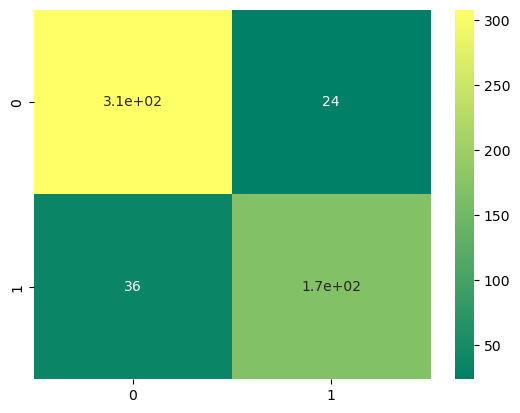

In [51]:
lr_clf = LogisticRegression(random_state=42)

model_accuracy(lr_clf,X_train,X_test,y_train,y_test)

              precision    recall  f1-score   support

           0       0.89      0.95      0.92       332
           1       0.91      0.81      0.86       205

    accuracy                           0.90       537
   macro avg       0.90      0.88      0.89       537
weighted avg       0.90      0.90      0.90       537



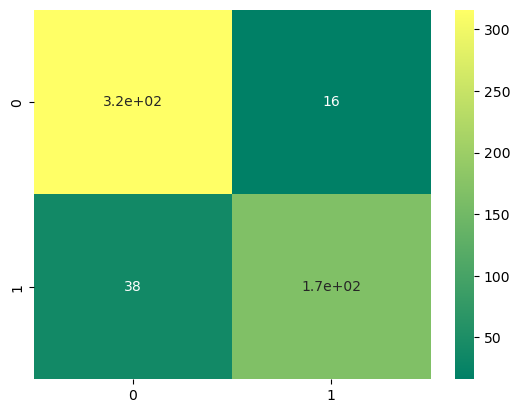

In [52]:
nb_clf = BernoulliNB()

model_accuracy(nb_clf,X_train,X_test,y_train,y_test)

#### Decision Tree Classifier

In [53]:
dt = DecisionTreeClassifier()

params_dt = {
'min_samples_split': range(1,10),
'criterion':['gini','entropy'],
'max_depth': range(1,10),
'min_samples_leaf': range(1,5)
}
# Instantiate a 10-fold CV grid search object 'grid_dt'
grid_dt = GridSearchCV(estimator=dt,
param_grid=params_dt,
scoring= 'r2',
cv=5,
n_jobs=-1)

grid_dt.fit(X_train, y_train)

# Extract best model from 'grid_dt'
best_modelDT = grid_dt.best_params_

In [54]:
DT_final = DecisionTreeClassifier(**best_modelDT)

              precision    recall  f1-score   support

           0       0.92      0.94      0.93       332
           1       0.90      0.87      0.89       205

    accuracy                           0.91       537
   macro avg       0.91      0.91      0.91       537
weighted avg       0.91      0.91      0.91       537



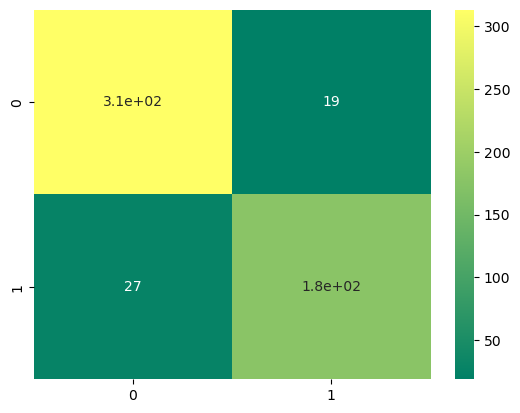

In [55]:
model_accuracy(DT_final,X_train,X_test,y_train,y_test)

#### RandomForest Classifier

In [56]:
rf_model = RandomForestClassifier()


# hyperparameter space
rf_param_grid = dict(
    n_estimators=[10, 20,40,50,100,150],
    max_depth=[5, 10, 15],
    min_samples_split=[2, 4,5],
    criterion = ['gini', 'entropy'],
#     max_features= ['auto', 'sqrt', 'log2']
)

# search
rf_clf = GridSearchCV(rf_model, rf_param_grid,
                   scoring='r2', cv=5, n_jobs = -1,verbose=1)

rf_clf.fit(X_train,y_train)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [5, 10, 15],
                         'min_samples_split': [2, 4, 5],
                         'n_estimators': [10, 20, 40, 50, 100, 150]},
             scoring='r2', verbose=1)

In [57]:
best_modelRF = rf_clf.best_params_

In [58]:
rf_final = RandomForestClassifier(**best_modelRF)

              precision    recall  f1-score   support

           0       0.92      0.96      0.94       332
           1       0.94      0.86      0.90       205

    accuracy                           0.93       537
   macro avg       0.93      0.91      0.92       537
weighted avg       0.93      0.93      0.92       537



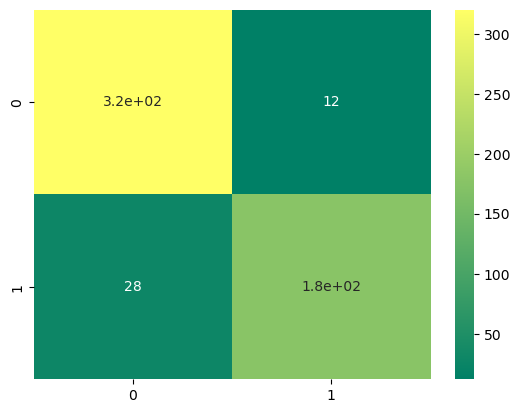

In [59]:
model_accuracy(rf_final,X_train,X_test,y_train,y_test)

#### XGBoost Classifier

In [60]:
param_dist = {
        'n_estimators':range(50,150,5),
        'max_depth':range(2,15,1),
        'learning_rate':np.linspace(0.01,1,25),
        'subsample':np.linspace(0.1,0.9,25),
        'colsample_bytree':np.linspace(0.3,0.8,20),
        'min_child_weight':range(1,9,1),
        'gamma': [0, 0.2,0.25, 0.3,0.35, 0.5, 1.0]

        }


xgbr = XGBClassifier()
XGB_Model = RandomizedSearchCV(xgbr,
                   param_dist,
                   scoring='r2',
                   verbose=1,
                    cv = 5,
                    n_iter=125,
                    n_jobs = -1)
XGB_Model.fit(X_train, y_train)
print("Best parameters:", XGB_Model.best_params_)

best_modelXGB = XGB_Model.best_params_



Fitting 5 folds for each of 125 candidates, totalling 625 fits
Best parameters: {'subsample': 0.7666666666666666, 'n_estimators': 55, 'min_child_weight': 1, 'max_depth': 10, 'learning_rate': 0.13375, 'gamma': 0.35, 'colsample_bytree': 0.8}


In [61]:
xgb_final = XGBClassifier(**best_modelXGB)

              precision    recall  f1-score   support

           0       0.94      0.95      0.95       332
           1       0.93      0.90      0.91       205

    accuracy                           0.93       537
   macro avg       0.93      0.93      0.93       537
weighted avg       0.93      0.93      0.93       537



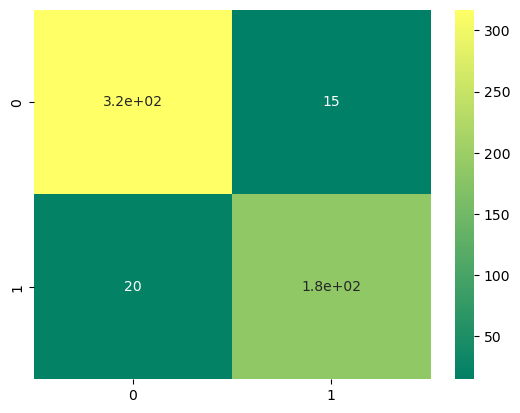

In [62]:
model_accuracy(xgb_final,X_train,X_test,y_train,y_test)